###### In this notebook I attempt to fit my data using a neural network with the fastai library. Here I am using only two output categories and find that my accuracy is much improved (~85%).

In [7]:
import pandas as pd
import numpy as np
import csv  

from sklearn.model_selection import train_test_split
import random
from datetime import datetime

from fastai.text import *

file_path_comments = '../Data/cleaned_comment_data.csv'
#file_path_comments = r'/mnt/c/Users/msteele9/Documents/Springboard/Springboard/Data/cleaned_comment_data.csv'

clean_comments = pd.read_csv(file_path_comments, index_col = False)

In [8]:
X = clean_comments['commentBody']
y = clean_comments['recommendations']
print(X[1])
y.head(5)

stunning photos and reportage infuriating that the trump admistrations draconian reinstatement of the global gag order will prevent men and women from receiving appropriate family planning advice so obviously desperately   needed


0    2.0
1    1.0
2    3.0
3    7.0
4    5.0
Name: recommendations, dtype: float64

## In this next cell, I convert my integer target, 'recommendations', to a category target. I create bins such as (-1 to 1), (1 to 25) and so on, placing my recommendation values in the correct bin.

In [9]:
#set up bins
bin = [-1, 1, 1000000]
label = [0, 1]
#use pd.cut function can attribute the values into its specific bins
category = pd.cut(y, bin, right = False, labels=label)
category = category.to_frame()
category.columns = ['range']
#concatenate age and its bin
df_new = pd.concat([y,category],axis = 1)

In [10]:
df_new.head(10)

,recommendations,range
0,2.0,1
1,1.0,1
2,3.0,1
3,7.0,1
4,5.0,1
5,8.0,1
6,9.0,1
7,1.0,1
8,0.0,0
9,60.0,1


### Here I create a crossfold validation split. I then merge the separated comments and recommendation counts into one dataframe containing training data and one dataframe containing test data, which fastai takes as inputs.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df_new['range'], test_size=0.2, random_state=random.seed(datetime.now()))

In [12]:
df_nlp_data_train = pd.concat([y_train, X_train], axis=1)
df_nlp_data_test = pd.concat([y_test, X_test], axis=1)

path = ''
data_lm = TextLMDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)
data_clas  = TextClasDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)

In [13]:
#data_clas.show_batch(1)

### In this cell I am creating my model using data blocks created using the text classifier with the LSTM model architecture.

In [15]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.metrics=[accuracy]
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2), moms=(0.8,0.7))
learn.save_encoder('enc')

epoch,train_loss,valid_loss,accuracy,time
0,5.278552,4.831021,0.193462,00:13


In [16]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.3)
learn.load_encoder('enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3999 items)
x: TextList
xxbos how about talking to people who did not vote and getting them motivated why is everyone xxunk on trump voters,xxbos elderly men pursuing younger women is about as sick as it gets,xxbos these women know fox is an difficult workplace why work xxunk bet the money helps them feel better about it all though,xxbos the republican war on taxes has been a class war on the great american middle class and the poor we came out of the second world war with a sense of destiny and belief in our country we built the greatest middle class the world had ever seen and were a xxunk to the world at the same time taxes on the wealthy were much higher yet we xxunk millions of americans owned their first home we built the great freeways we sent our children to college without terrible debt burdens we went to the moon we had faith that the people are the government and had faith in our selves and our xxunk civil rights movement

In [17]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-02
Min loss divided by 10: 1.45E-02


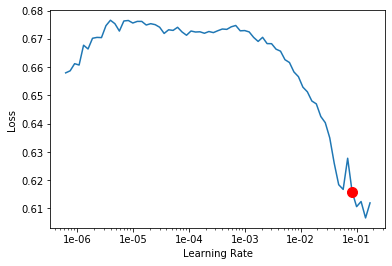

In [18]:
learn.recorder.plot(suggestion=True, skip_end=15)
min_grad_lr=learn.recorder.min_grad_lr

In [19]:
learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.411439,0.407498,0.862000,00:44


In [20]:
learn.save('fit_lstm_binary_5k')

In [21]:
learn.load('fit_lstm_binary_5k');

In [38]:
learn.unfreeze()

In [39]:
#save_path = r'~/Documents/Springboard/Springboard/Models/'
#data_lm.save('~/Documents/Springboard/Springboard/Models/')

Here we get the predictions of the validation set, then print a sample of predictions. This is to verify that the model is not defaulting to a trivial output such as putting all predictions in the same category.

In [40]:
preds, y_predict, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y_predict)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.8539999723434448 %.


Text(0.5, 1.0, 'Predictions')

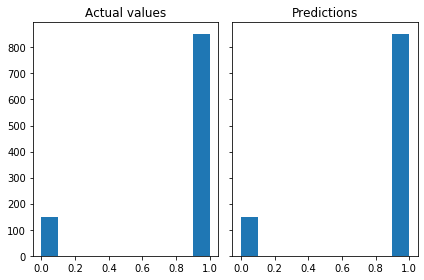

In [41]:
n_bins=10

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(y_test[:10000], bins=n_bins)
#axs[0].set_yscale('log')
axs[0].set_title('Actual values')
axs[1].hist(y_predict[:10000], bins=n_bins)
#axs[1].set_yscale('log')
axs[1].set_title('Predictions')

In [42]:
act_vs_pred = pd.concat([y_test[:10000].reset_index(), pd.Series(y_predict[:10000].numpy())], axis=1, ignore_index=True).drop(columns=[0])
act_vs_pred.columns = (['actual', 'predict'])
print(act_vs_pred.head(50))

#print(act_vs_pred.groupby(1).count())
#print(act_vs_pred.groupby(2).count())
print(act_vs_pred['actual'].value_counts())
print(act_vs_pred['predict'].value_counts())

   actual  predict
0       1        0
1       1        1
2       1        1
3       1        1
4       1        1
5       1        1
6       1        1
7       1        1
8       1        1
9       1        1
10      0        1
11      1        1
12      0        1
13      1        1
14      1        1
15      1        1
16      1        1
17      1        1
18      1        1
19      1        1
20      1        1
21      1        1
22      1        1
23      1        1
24      1        1
25      1        1
26      1        0
27      1        1
28      0        1
29      1        1
30      0        1
31      1        1
32      1        1
33      1        1
34      1        1
35      1        1
36      0        1
37      1        1
38      1        1
39      1        1
40      1        1
41      1        1
42      1        1
43      1        1
44      0        1
45      1        0
46      1        1
47      1        1
48      1        1
49      1        1
1    853
0    147
Name: actual,

In [44]:
pd.crosstab(act_vs_pred['actual'], act_vs_pred['predict'])

predict,0,1
actual,,
0,22,125
1,125,728
